# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np

import fastf1
from fastf1.ergast import Ergast

from tqdm import tqdm
import os

import sys
sys.path.append('../')

In [8]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Machine learning imports
# -----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import *
from src.classification import *

# 2. Data loading

In [9]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [10]:
df.columns

Index(['DriverId', 'TeamId', 'Position', 'GridPosition', 'Time', 'Status',
       'Points', 'season', 'round', 'circuitId', 'Winner', 'Podium',
       'MeanPreviousGrid', 'MeanPreviousPosition', 'CurrentDriverPoints',
       'CurrentDriverWins', 'CurrentDriverPodiums', 'CurrentTeamPoints'],
      dtype='object')

# 3. Preprocess

### Column Analysis

| Column                    | Data Type   | Observations                                                                |
|---------------------------|------------|-----------------------------------------------------------------------------|
| `DriverId`                | `object`    | Categorical, requires encoding.                                             |
| `TeamId`                  | `object`    | Categorical, requires encoding.                                             |
| `Position`                | `float64`   | Continuous, represents positions; requires scaling.                         |
| `GridPosition`            | `float64`   | Continuous, represents starting grid positions; requires scaling.           |
| `Time`                    | `float64`   | Continuous, represents race time; requires scaling.                         |
| `Status`                  | `object`    | Categorical, requires encoding.                                             |
| `Points`                  | `float64`   | Continuous, represents race points; requires scaling.                       |
| `season`                  | `int64`     | Discrete numeric, requires encoding or scaling depending on its role.       |
| `round`                   | `int64`     | Discrete numeric, represents ordinal data; requires ordinal encoding.       |
| `circuitId`               | `object`    | Categorical, requires encoding.                                             |
| `Winner`                  | `int64`     | Binary, already encoded as 0/1.                                             |
| `Podium`                  | `int64`     | Binary, already encoded as 0/1.                                             |
| `MeanPreviousGrid`        | `float64`   | Continuous, represents the average grid position in previous races; requires scaling. |
| `MeanPreviousPosition`    | `float64`   | Continuous, represents the average finishing position in previous races; requires scaling. |
| `CurrentDriverPoints`     | `float64`   | Continuous, represents cumulative driver points; requires scaling.          |
| `CurrentDriverWins`       | `int64`     | Discrete numeric, represents cumulative driver wins; requires scaling.      |
| `CurrentDriverPodiums`    | `int64`     | Discrete numeric, represents cumulative driver podiums; requires scaling.   |
| `CurrentTeamPoints`       | `float64`   | Continuous, represents cumulative team points; requires scaling.            |

### Encoding Strategy

1. **Nominal Categorical Variables**:
   - `DriverId`, `TeamId`, `Status`, and `circuitId` are unordered categorical variables.

   - **One-Hot Encoding** is suitable for `DriverId` and `TeamId` if the number of unique values is limited. Otherwise, **Target Encoding** can be used.

   - For `Status` and `circuitId`, due to potentially many levels, **Target Encoding** is preferred.

2. **Ordinal Categorical Variables**:
   - `round` represents ordered values and should use **Ordinal Encoding**.
   
   - Ensure that the order aligns with the natural numerical order of the rounds.

3. **Binary Variables**:
   - `Winner` and `Podium` are already binary and require no further transformation.

### Scaling Strategy

1. **Continuous Variables**:
   - `Position`, `GridPosition`, `Time`, `Points`, `DriverPointsCumulative`, `TeamPointsCumulative`, `WinsCumulative`, `PodiumsCumulative`, `MeanPreviousGrid`, and `MeanPreviousPosition` require scaling.

   - Depending on the presence of outliers:
     - Use **Standard Scaling** for normally distributed data.
     
     - Use **Min-Max Scaling** if the data has no significant outliers and needs normalization within a specific range.

2. **Discrete Variables**:
   - `season` and `round` may be scaled or encoded depending on their role in modeling. If used as categorical features, encode them; if treated as continuous, scale them.

Como queremos predecir si un piloto va a ganar una carrera, necesitamos eliminar las columnas que contengan información sobre el resultado de la carrera, ya que no podemos proporcionar como input un dato de algo que todavía no ha ocurrido.

Nuestra target variable es en este caso `Winner` (podría ser `Podium` si queremos predecir si va a quedar en el podio, `Position` si queremos predecir la posición exacta, etc)

De esta forma podemos eliminar `Position`, `Time`, `Status`, `Points`, `Podium`. El resto de variables sí las podemos conocer antes de disputarse la carrera.

In [11]:
df.drop(columns=['Position', 'Time', 'Status', 'Points', 'Podium'], inplace=True)

In [12]:
df.isna().sum()

DriverId                0
TeamId                  0
GridPosition            0
season                  0
round                   0
circuitId               0
Winner                  0
MeanPreviousGrid        0
MeanPreviousPosition    0
CurrentDriverPoints     0
CurrentDriverWins       0
CurrentDriverPodiums    0
CurrentTeamPoints       0
dtype: int64

No tenemos valores nulos, por lo que podemos continuar.

### Encoding

In [14]:
df.select_dtypes(include='O').columns

Index(['DriverId', 'TeamId', 'circuitId'], dtype='object')

In [15]:
encoding_methods = {"onehot": ['TeamId'],
                    "target": ['DriverId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }

encoder = Encoding(df, encoding_methods, 'Winner')

In [16]:
df_encoded = encoder.execute_all_encodings()

Scaling

In [29]:
df_scaled = scale_df(df_encoded, df_encoded.columns.to_list(), method="minmax")

In [31]:
df_scaled

,DriverId,GridPosition,season,round,Winner,MeanPreviousGrid,MeanPreviousPosition,CurrentDriverPoints,CurrentDriverWins,CurrentDriverPodiums,...,TeamId_caterham,TeamId_ferrari,TeamId_haas,TeamId_hrt,TeamId_manor,TeamId_mclaren,TeamId_mercedes,TeamId_red_bull,TeamId_williams,circuitId
0,1.394928e-01,0.125000,0.0,0.0,1.0,0.125000,0.000000,0.000000,0.000000,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1.957202e-07,0.083333,0.0,0.0,0.0,0.083333,0.043478,0.000000,0.000000,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1.000000e+00,0.166667,0.0,0.0,0.0,0.166667,0.086957,0.000000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
3,5.684317e-01,0.041667,0.0,0.0,0.0,0.041667,0.130435,0.000000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
4,5.147025e-01,0.208333,0.0,0.0,0.0,0.208333,0.173913,0.000000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949,6.466070e-02,0.833333,1.0,1.0,0.0,0.625000,0.579710,0.001984,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.529412
5950,1.194671e-02,0.791667,1.0,1.0,0.0,0.777778,0.666667,0.011905,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529412
5951,3.290247e-02,0.666667,1.0,1.0,0.0,0.486111,0.391304,0.353175,0.055556,0.15,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529412
5952,1.364788e-01,0.750000,1.0,1.0,0.0,0.597222,0.710145,0.019841,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529412


# 4. Model selection

Estamos evaluendo un modelo que predice si un piloto ganará una carrera. En este caso queremos minimizar el número de errores en general, ya que es igual de malo predecir que un piloto va a ganar y equivocarnos que predecir que no lo va a hacer y sí lo haga.

Por lo tanto, trataremos mazimizar la métrica `f1_score` lo máximo posible ya que es un compromiso entre `precision`y `recall`.

In [294]:
models = ClassificationModels(df_scaled, 'Winner')

In [295]:
df_results = pd.DataFrame()

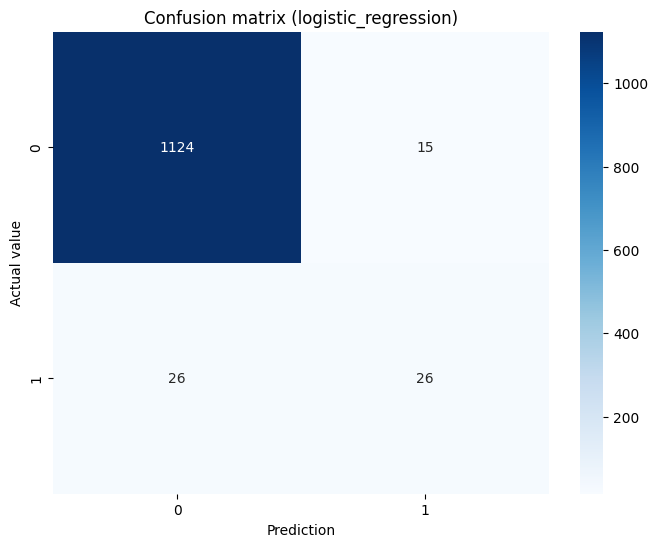

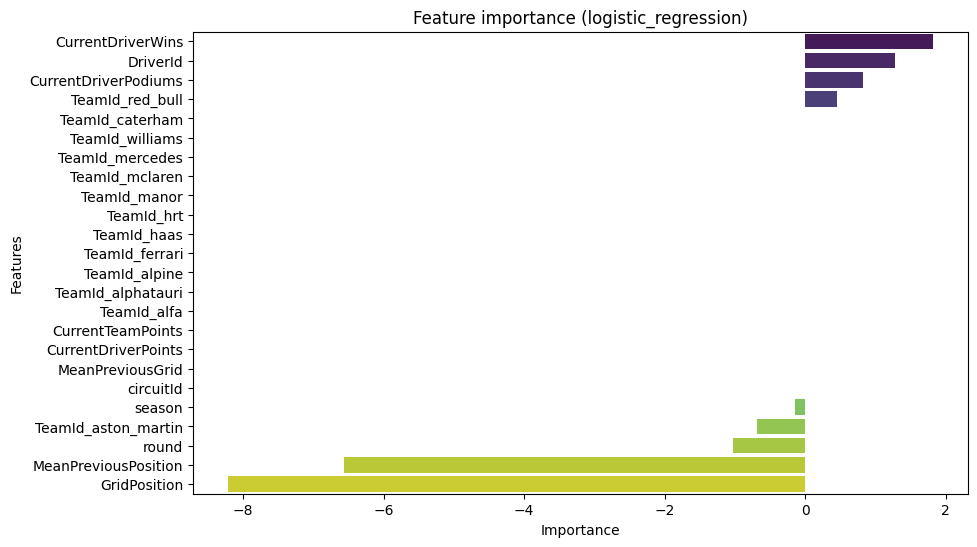

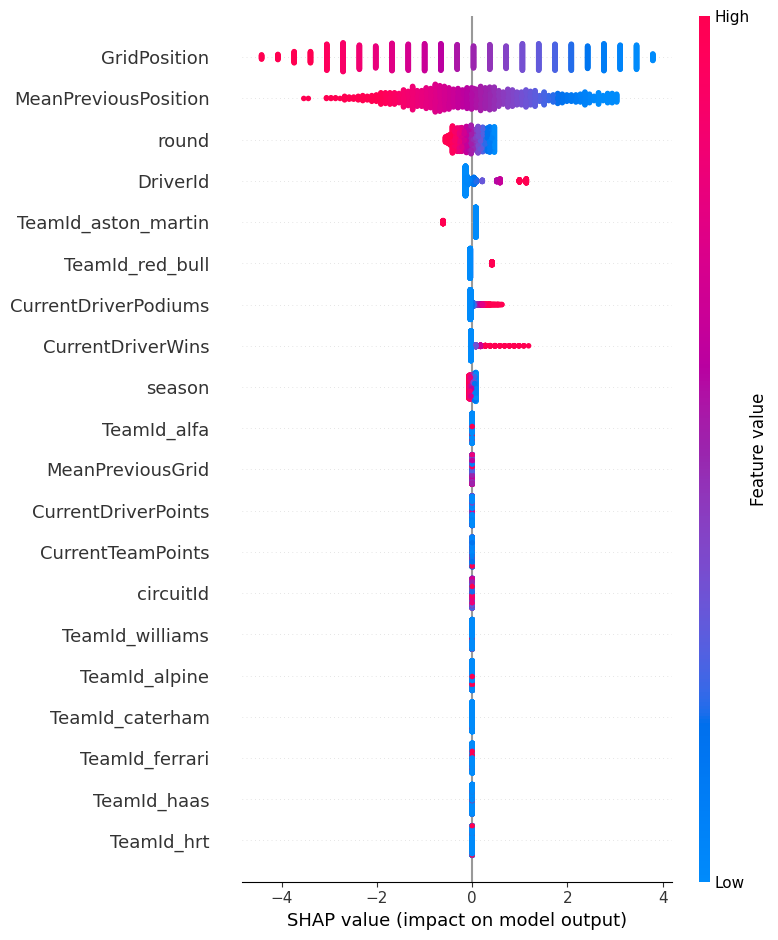

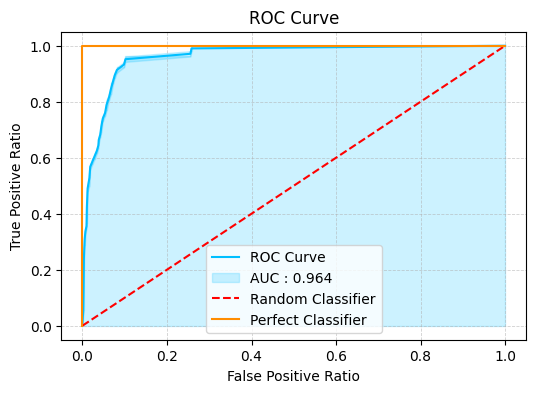

In [296]:
# model_list = ["logistic_regression", "tree", "random_forest", "gradient_boosting", "xgboost"]
model_list = ["logistic_regression"]

for model in model_list:

    models.fit_model(model, file_name=model)
    models.plot_confusion_matrix(model)
    models.plot_predictors_importance(model)
    models.plot_shap_summary(model)
    df_current_results = models.get_metrics(model)
    df_current_results["model"] = model
    df_results = pd.concat([df_results, df_current_results], axis=0)
    models.plot_roc_curve(model)

In [297]:
df_results

,accuracy,precision,recall,f1,kappa,auc,time_seconds,cores,model
train,0.965358,0.960932,0.965358,0.961681,0.542887,0.966187,18.763989,NaN,logistic_regression
test,0.965575,0.962405,0.965575,0.963622,0.541489,0.964155,18.763989,NaN,logistic_regression


---

In [303]:
entry = 0
pd.DataFrame(models.X.loc[entry]).T

,DriverId,GridPosition,season,round,MeanPreviousGrid,MeanPreviousPosition,CurrentDriverPoints,CurrentDriverWins,CurrentDriverPodiums,CurrentTeamPoints,...,TeamId_caterham,TeamId_ferrari,TeamId_haas,TeamId_hrt,TeamId_manor,TeamId_mclaren,TeamId_mercedes,TeamId_red_bull,TeamId_williams,circuitId
0,0.139493,0.125,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [304]:
pd.DataFrame(df.iloc[entry]).T

,DriverId,GridPosition,Winner,MeanPreviousGrid,MeanPreviousPosition,CurrentDriverWins,CurrentDriverPodiums,TeamId_alfa,TeamId_alphatauri,TeamId_alpine,TeamId_aston_martin,TeamId_ferrari,TeamId_haas,TeamId_hrt,TeamId_manor,TeamId_mclaren,TeamId_mercedes,TeamId_red_bull,TeamId_williams,circuitId
0,0.135908,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
models.results['logistic_regression']['best_model'].predict_proba(pd.DataFrame(models.X.loc[entry]).T)

array([[0.73949479, 0.26050521]])

---

Next steps: Utilizar datos de los entrenamientos libres para enriquecer el modelo

In [306]:
model_name = model_list[0]

pred_train = models.results[model_name]["pred_train"]
pred_test = models.results[model_name]["pred_test"]

model = models.results[model_name]["best_model"]

metrics_train = {
    "accuracy": accuracy_score(models.y_train, pred_train),
    "precision": precision_score(models.y_train, pred_train),
    "recall": recall_score(models.y_train, pred_train),
    "f1": f1_score(models.y_train, pred_train)
    }

metrics_test = {
    "accuracy": accuracy_score(models.y_test, pred_test),
    "precision": precision_score(models.y_test, pred_test),
    "recall": recall_score(models.y_test, pred_test),
    "f1": f1_score(models.y_test, pred_test)
    }


In [307]:
metrics_test

{'accuracy': 0.9655751469353484,
 'precision': 0.6341463414634146,
 'recall': 0.5,
 'f1': 0.5591397849462365}

In [308]:
pred_test = models.results[model_name]["pred_test"]

# Confusion matrix
matrix = confusion_matrix(models.y_test, pred_test)

In [309]:
matrix

array([[1124,   15],
       [  26,   26]])

---

In [310]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [311]:
threshold = 5

mask = (df['Position'] < threshold) | (df['GridPosition'] < threshold)

df = df[mask]
df.drop(columns=['Position', 'Time', 'Status', 'Points', 'Podium'], inplace=True)

In [312]:
df.shape

(1535, 13)

In [313]:
df.drop(columns=['season', 'round', 'CurrentDriverPoints', 'CurrentTeamPoints'], inplace=True)

In [314]:
encoding_methods = {"onehot": ['TeamId'],
                    "target": ['DriverId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }

encoder = Encoding(df, encoding_methods, 'Winner')

df_encoded = encoder.execute_all_encodings()

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       251
           1       0.48      0.79      0.59        56

    accuracy                           0.80       307
   macro avg       0.71      0.80      0.73       307
weighted avg       0.86      0.80      0.82       307



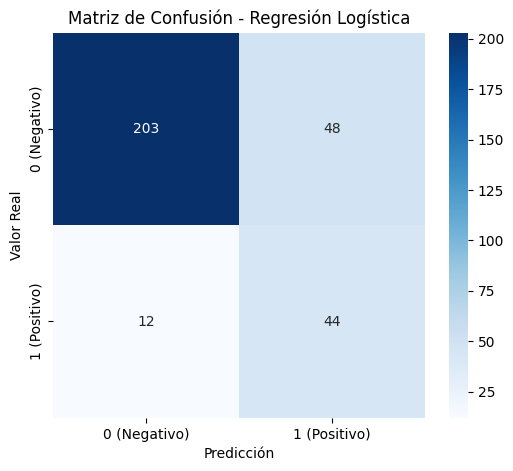

In [315]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar tus datos aquí si es necesario
df = df_encoded
target = 'Winner'
X = df.drop(target, axis=1)  # Reemplaza "target" con el nombre de la columna objetivo
y = df[target]

# 2. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenar la Regresión Logística con ajuste de pesos para clases desbalanceadas
model = LogisticRegression(class_weight='balanced', random_state=42)
#model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Hacer predicciones
y_pred = model.predict(X_test_scaled)

# 6. Evaluación del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0 (Negativo)", "1 (Positivo)"], yticklabels=["0 (Negativo)", "1 (Positivo)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

In [316]:
metrics_test = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    }

metrics_test

{'accuracy': 0.8045602605863192,
 'precision': 0.4782608695652174,
 'recall': 0.7857142857142857,
 'f1': 0.5945945945945946}

In [317]:
importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.coef_[0]
}).sort_values(by="Importance", ascending=False)

importances_df

,Feature,Importance
4,CurrentDriverWins,1.707184
0,DriverId,1.278123
7,TeamId_alphatauri,0.540279
16,TeamId_red_bull,0.516716
14,TeamId_mclaren,0.293847
15,TeamId_mercedes,0.253813
8,TeamId_alpine,0.159960
13,TeamId_manor,-0.025628
5,CurrentDriverPodiums,-0.029752
12,TeamId_hrt,-0.059521
